In [1]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import random
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils
from tensorflow.keras.regularizers import l1, l2, l1_l2

from IPython.display import display, clear_output

sns.set_theme()

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/cpu:0", "/gpu:0"])
print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:GPU:0')
GPUs für die Berechnung: 0


In [2]:
#Metadaten einlesen
df = pd.read_csv("NIHMS841832-supplement-1.csv", sep=',')
    
#Ergebnisse des Feature Tables einlesen
feature = pd.read_csv('feature_table.txt', sep='\t').T
feature = feature[1:][:-1]

feature

,0,1,2,3,4,5,6,7,8,9,...,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110
1629.SubjectIBD335,34292.0,20670.0,18413.0,9981.0,7071.0,6881.0,5411.0,5335.0,5289.0,4741.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD643,15243.0,64328.0,0.0,0.0,0.0,4.0,4507.0,3216.0,15630.0,199.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD539,22182.0,21589.0,0.0,1365.0,0.0,11501.0,33619.0,3638.0,5053.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD078,0.0,805.0,0.0,0.0,0.0,4.0,330.0,2305.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD671,0.0,19734.0,0.0,0.0,0.0,0.0,215.0,0.0,0.0,699.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD421,5154.0,12101.0,1572.0,62.0,190.0,1448.0,6316.0,2205.0,1885.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD202,14565.0,24920.0,3543.0,0.0,0.0,0.0,63.0,0.0,37768.0,48660.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD544,32.0,52.0,31.0,0.0,0.0,2.0,18543.0,0.0,3.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,946.0,31.0
1629.SubjectIBD422,5718.0,18420.0,9534.0,0.0,0.0,0.0,4791.0,2770.0,0.0,588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Gesunde Kontrollgruppe
HC = df[df.ibd_subtype.eq("HC")]

#CCD
CCD = df[df.ibd_subtype.eq("CCD")]
    
#ICD-r
ICD_r = df[df.ibd_subtype.eq("ICD_r")]

#ICD-nr
ICD_nr = df[df.ibd_subtype.eq("ICD_nr")]
    
#UCD
UC = df[df.ibd_subtype.eq("UC")]

In [4]:
#Splitt nach Patient. Alle Zeitpunkte eines Patienten entweder in Train oder Test.
def split_function(tSize, random_state, table, metadata, hc_group):
    patientSamples = {}
    liste = []

    for row in metadata.index:
        liste.append(metadata['patientnumber'][row])

    menge = set(liste)  

    for e in menge:
        newPatient = metadata[metadata.patientnumber.eq(e)]
        patientSamples[e] = list(newPatient['sample_name'])

    shuffleListe = list(menge)
    random.Random(random_state).shuffle(shuffleListe)

    #Split
    trainSize = int(np.round(tSize * len(shuffleListe), 0))
    testSize = len(shuffleListe) - trainSize

    X_trainEntry = shuffleListe[0:trainSize]
    X_testEntry = shuffleListe[trainSize:len(shuffleListe)]

    X_train = []
    y_train = []
    for i in X_trainEntry:
        try:
            value = patientSamples[i]
            for sample_name in value:
                for row in table.index:
                    if(row == sample_name):
                        temp = table.loc[[row]].values[0]
                        X_train.append(temp)
                        if any(True for val in hc_group['sample_name'] if val == row):
                            y_train.append(1)
                        else:
                            y_train.append(0)
        except KeyError as e:
            fehler += 1
            print('I got a KeyError - reason "%s"' % str(e))


    X_test = []   
    y_test = []
    for i in X_testEntry:
        try:
            value = patientSamples[i]
            for sample_name in value:
                for row in table.index:
                    if(row == sample_name):
                        temp = table.loc[[row]].values[0]
                        X_test.append(temp)
                        if any(True for val in hc_group['sample_name'] if val == row):
                            y_test.append(1)
                        else:
                            y_test.append(0)
        except KeyError as e:
            fehler += 1
            print('I got a KeyError - reason "%s"' % str(e))

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
def nn(i):
    #Split Test und Trainingsdaten für jede Gruppe
    X_trainHC, X_testHC, y_trainHC, y_testHC = split_function(tSize=0.5, random_state=i, table=feature, metadata=HC, hc_group=HC)
    X_trainCCD, X_testCCD, y_trainCCD, y_testCCD = split_function(tSize=0.75, random_state=i, table=feature, metadata=CCD, hc_group=HC)
    X_trainICD_r, X_testICD_r, y_trainICD_r, y_testICD_r = split_function(tSize=0.75, random_state=i, table=feature, metadata=ICD_r, hc_group=HC)
    X_trainICD_nr, X_testICD_nr, y_trainICD_nr, y_testICD_nr = split_function(tSize=0.75, random_state=i, table=feature, metadata=ICD_nr, hc_group=HC)
    X_trainUC, X_testUC, y_trainUC, y_testUC = split_function(tSize=0.75, random_state=i, table=feature, metadata=UC, hc_group=HC)

    X_train = np.concatenate((X_trainHC,  X_trainCCD,  X_trainICD_r,  X_trainICD_nr, X_trainUC), axis=0)
    X_test = np.concatenate((X_testHC,  X_testCCD,  X_testICD_r,  X_testICD_nr, X_testUC), axis=0)
    y_train = np.concatenate((y_trainHC,  y_trainCCD,  y_trainICD_r,  y_trainICD_nr, y_trainUC), axis=0)
    y_test = np.concatenate((y_testHC,  y_testCCD,  y_testICD_r,  y_testICD_nr, y_testUC), axis=0)


    trainSize = len(X_train)/(len(X_train)+len(X_test))
    testSize =len(X_test)/(len(X_train)+len(X_test)) 

    HCTrainSize = len(X_trainHC)/(len(X_trainHC)+len(X_testHC))
    HCTestSize = len(X_testHC)/(len(X_trainHC)+len(X_testHC))                          

    CCDTrainSize = len(X_trainCCD)/(len(X_trainCCD)+len(X_testCCD))
    CCDTestSize = len(X_testCCD)/(len(X_trainCCD)+len(X_testCCD))   

    ICD_rTrainSize = len(X_trainICD_r)/(len(X_trainICD_r)+len(X_testICD_r))
    ICD_rTestSize = len(X_testICD_r)/(len(X_trainICD_r)+len(X_testICD_r)) 

    ICD_nrTrainSize = len(X_trainICD_nr)/(len(X_trainICD_nr)+len(X_testICD_nr))
    ICD_nrTestSize = len(X_testICD_nr)/(len(X_trainICD_nr)+len(X_testICD_nr)) 

    UCTrainSize = len(X_trainUC)/(len(X_trainUC)+len(X_testUC))
    UCTestSize = len(X_testUC)/(len(X_trainUC)+len(X_testUC))  


    #Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001,
        patience=64,
        restore_best_weights=True
    )


    #class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

    # Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
    # Dropout führt allem Anschein nach zu schlechterem F1
    # Weniger LUs führen zu besseren Ergebnissen
    with mirrored_strategy.scope():
        network = keras.Sequential([
            #layers.BatchNormalization(),
            layers.Dense(48, activation='sigmoid', input_shape=[X_train.shape[1]]),
            layers.Dense(48, activation='sigmoid'),
            layers.Dense(48, activation='sigmoid'),
            layers.Dense(2, activation='softmax'),
            layers.Dense(1, activation='sigmoid'),
        ])

        # NN kompilieren
        network.compile(
            optimizer='adamax',
            loss='binary_crossentropy',
            metrics=[keras.metrics.BinaryAccuracy()]
        )

        # NN trainieren
        history = network.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=179,
            #class_weight=class_weights,
            epochs=512,
            callbacks=[early_stopping],
            verbose=0
        )

    # Scores berechnen
    history_df = pd.DataFrame(history.history)

    y_pred = network.predict(X_test)
    #print(y_pred)
    y_pred_corrected = []

    for pred in y_pred:
        if pred >= 0.5:
            y_pred_corrected.append(1)
        else: 
            y_pred_corrected.append(0)
            
    f1 = f1_score(y_test, y_pred_corrected, average='macro')

    print(str(0) + ": " + "f1_score: " + str(f1) + "    " + str(np.round(trainSize, 2)) +"/"+ str(np.round(testSize, 2)) + " Gesamt-Split")
    print(str(np.round(HCTrainSize, 2)) +"/"+ str(np.round(HCTestSize, 2)) + " HC-Split")
    print(str(np.round(CCDTrainSize, 2)) +"/"+ str(np.round(CCDTestSize, 2)) + " CCD-Split")
    print(str(np.round(ICD_rTrainSize, 2)) +"/"+ str(np.round(ICD_rTestSize, 2)) + " ICD_r-Split")
    print(str(np.round(ICD_nrTrainSize, 2)) +"/"+ str(np.round(ICD_nrTestSize, 2)) + " ICD_nr-Split")
    print(str(np.round(UCTrainSize, 2)) +"/"+ str(np.round(UCTestSize, 2)) + " UC-Split")

    report = sklearn.metrics.classification_report(y_test, y_pred_corrected)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_corrected)
    print(confusion_matrix)
    print(report)
    history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
    history_df.loc[5:, ['loss', 'val_loss']].plot()

    return f1, report, network

,model,f1,report
0,<tensorflow.python.keras.engine.sequential.Seq...,0.442368,precision recall f1-score ...


KeyboardInterrupt: 

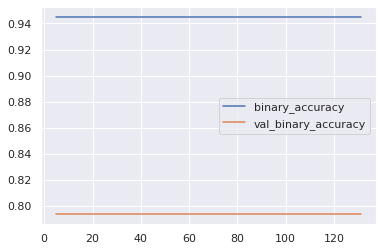

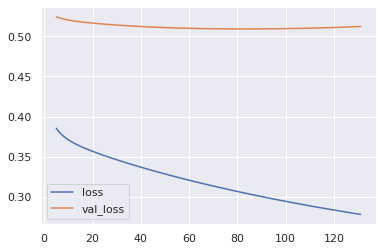

In [6]:
# 100 verschiedene Modelle trainieren und in einen DataFrame speichern
# Das kann ein paar Stunden dauern

results = {}

for i in np.arange(20):
    f1, report, model = nn(i)
    results[i] = [model, f1, report]
    clear_output()
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['model', 'f1', 'report'])
    display(df_results)


#df_results

In [ ]:
# DataFrame nach bestem F1-Score sortieren
df_results_sorted = df_results.sort_values(by=['f1'], ascending=False)

# Die besten 10 Modelle speichern
#for i in np.arange(10):
#    df_results_sorted.iloc[i].model.save(f'models/best_otu/model{i}.h5')

In [ ]:
df_results.describe()